In [1]:
from math import radians, cos, sin, asin, sqrt 
def calculate_distance(lon1, lat1, lon2, lat2): 
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2]) 
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2 
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371 
    km = 6371* c 
    return km

In [2]:
def next_cluster(lng,lat,cluster_df):
    smallest_value = 9999999999999999 #nicht schön aber sollte funktionieren.
    for index, row in cluster_df.iterrows():
        cluster_lng = row["lng"]
        cluster_lat = row["lat"]
        distance = calculate_distance(lng,lat,cluster_lng,cluster_lat)
        if distance < smallest_value:
            smallest_value = distance
            closest_cluster = [cluster_lng,cluster_lat]
    return closest_cluster

# Task 1

## Import Libraries

In [3]:
import pandas as pd
import numpy as np

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

In [5]:
import geopandas as gpd

ModuleNotFoundError: No module named 'geopandas'

## Import raw data and merge the data

In [7]:
Nextbike_bochum= pd.read_csv("./dataset/bochum.csv")
Nextbike_leipzig = pd.read_csv("./dataset/leipzig.csv")
Nextbike = Nextbike_bochum.append(Nextbike_leipzig)

Nextbike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202697 entries, 0 to 185326
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   day            202697 non-null  object 
 1   time           202697 non-null  object 
 2   b_number       202697 non-null  int64  
 3   city           202697 non-null  object 
 4   trip_duration  202697 non-null  object 
 5   orig_lat       202697 non-null  float64
 6   orig_lng       202697 non-null  float64
 7   dest_lat       202697 non-null  float64
 8   dest_lng       202697 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 15.5+ MB


In [8]:
date_info_leipzig = pd.read_csv("./resources/leipzig-holidays/leipzig-holidays.csv",sep=";")
date_info_leipzig["date"] = pd.to_datetime(date_info_leipzig["date"],format="%d.%m.%Y").dt.date
date_info_leipzig.index = date_info_leipzig["date"]


## Look for null values

In [9]:
Nextbike.isnull().sum().sort_values(ascending=False)

dest_lng         0
dest_lat         0
orig_lng         0
orig_lat         0
trip_duration    0
city             0
b_number         0
time             0
day              0
dtype: int64

## Correct Data Types

In [10]:
#Converting Trip Length to timedelta
Nextbike['trip_duration'] = pd.to_timedelta(Nextbike['trip_duration'])

#Converting start-time to datetime
Nextbike['timestamp'] = pd.to_datetime(Nextbike['day'] + ' ' +  Nextbike['time'])
Nextbike.drop(columns=['day','time'], inplace = True)

## Add columns for analysis

In [11]:
#Round datetime and extract possible categorisation attributes
Nextbike['timestamp_rounded'] = Nextbike['timestamp'].dt.floor('H')

Nextbike['weekday'] = Nextbike['timestamp_rounded'].dt.weekday
Nextbike['week'] = Nextbike['timestamp_rounded'].dt.isocalendar().week

Nextbike['Time'] = Nextbike['timestamp_rounded'].dt.time
Nextbike["Time"] = Nextbike["Time"].astype(str).str[:2].astype(int)

Nextbike["date"] = Nextbike.timestamp.dt.date
#Nextbike_clean["date_str"] = Nextbike_clean.timestamp.dt.date.astype(str)

#take trip duration in minutes, calculate 1€ per 30 minutes of usage
Nextbike["revenue"] = np.ceil((Nextbike.trip_duration.dt.total_seconds()/60) /30)


#output
Nextbike

,b_number,city,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,timestamp,timestamp_rounded,weekday,week,Time,date,revenue
0,683,bochum,0 days 00:10:00,51.489814,7.232856,51.479592,7.222239,2019-02-08 12:06:00,2019-02-08 12:00:00,4,6,12,2019-02-08,1.0
1,683,bochum,0 days 00:14:00,51.479592,7.222239,51.472366,7.250500,2019-02-10 01:58:00,2019-02-10 01:00:00,6,6,1,2019-02-10,1.0
2,683,bochum,0 days 00:28:00,51.472366,7.250500,51.479592,7.222239,2019-02-11 06:33:00,2019-02-11 06:00:00,0,7,6,2019-02-11,1.0
3,683,bochum,0 days 00:58:00,51.479592,7.222239,51.483023,7.215314,2019-02-11 13:31:00,2019-02-11 13:00:00,0,7,13,2019-02-11,2.0
4,683,bochum,0 days 00:22:00,51.483023,7.215314,51.479592,7.222239,2019-02-11 14:32:00,2019-02-11 14:00:00,0,7,14,2019-02-11,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185322,99979,leipzig,0 days 00:07:00,51.468822,11.290048,51.468547,11.289899,2019-05-25 10:58:00,2019-05-25 10:00:00,5,21,10,2019-05-25,1.0
185323,99979,leipzig,0 days 01:16:00,51.468756,11.289723,51.469324,11.289366,2019-05-27 09:32:00,2019-05-27 09:00:00,0,22,9,2019-05-27,3.0
185324,99979,leipzig,0 days 00:03:00,51.469044,11.289348,51.469093,11.289432,2019-05-27 11:02:00,2019-05-27 11:00:00,0,22,11,2019-05-27,1.0
185325,99982,leipzig,0 days 01:44:00,51.341165,12.365045,51.341065,12.365005,2019-02-11 11:47:00,2019-02-11 11:00:00,0,7,11,2019-02-11,4.0


## Split data for analysis

In [12]:
Nextbike_clean_l = Nextbike[Nextbike.city == "leipzig"]
Nextbike_clean_b = Nextbike[Nextbike.city == "bochum"]

leipzig = {"lng": 12.3741468,"lat": 51.340744}

city = leipzig
df = Nextbike_clean_l.copy()
date_info = date_info_leipzig.copy()

## Cleaning up unrealistic rides
This step is aimed at filtering out rides that have start or end locations far out from the city and thus is likely not a regular ride within the valid area

In [13]:
max_distance_center = []

for index, row in df.iterrows():
    s = calculate_distance(lon1 = row["orig_lng"],
                       lat1 = row["orig_lat"],
                       lon2 = city["lng"],
                       lat2 = city["lat"])
    e = calculate_distance(lon1 = row["dest_lng"], 
                           lat1 = row["dest_lat"],
                           lon2 = city["lng"],
                           lat2 = city["lat"])
    max_distance_center.append(max([s,e]))

df["max_distance_center"] = max_distance_center
df

,b_number,city,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,timestamp,timestamp_rounded,weekday,week,Time,date,revenue,max_distance_center
0,10900,leipzig,0 days 00:12:00,51.330271,12.341983,51.330347,12.342159,2019-04-16 11:17:00,2019-04-16 11:00:00,1,16,11,2019-04-16,1.0,2.519655
1,10900,leipzig,0 days 00:08:00,51.330347,12.342159,51.330271,12.342199,2019-04-16 11:35:00,2019-04-16 11:00:00,1,16,11,2019-04-16,1.0,2.506386
2,10900,leipzig,0 days 00:40:00,51.330267,12.342196,51.330236,12.342012,2019-04-16 11:53:00,2019-04-16 11:00:00,1,16,11,2019-04-16,2.0,2.519708
3,10900,leipzig,0 days 00:03:00,51.330298,12.341811,51.330267,12.341958,2019-04-16 14:35:00,2019-04-16 14:00:00,1,16,14,2019-04-16,1.0,2.528907
4,20000,leipzig,0 days 00:20:00,51.343107,12.376471,51.330422,12.337838,2019-05-21 09:47:00,2019-05-21 09:00:00,1,21,9,2019-05-21,1.0,2.771228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185322,99979,leipzig,0 days 00:07:00,51.468822,11.290048,51.468547,11.289899,2019-05-25 10:58:00,2019-05-25 10:00:00,5,21,10,2019-05-25,1.0,76.539147
185323,99979,leipzig,0 days 01:16:00,51.468756,11.289723,51.469324,11.289366,2019-05-27 09:32:00,2019-05-27 09:00:00,0,22,9,2019-05-27,3.0,76.590965
185324,99979,leipzig,0 days 00:03:00,51.469044,11.289348,51.469093,11.289432,2019-05-27 11:02:00,2019-05-27 11:00:00,0,22,11,2019-05-27,1.0,76.586597
185325,99982,leipzig,0 days 01:44:00,51.341165,12.365045,51.341065,12.365005,2019-02-11 11:47:00,2019-02-11 11:00:00,0,7,11,2019-02-11,4.0,0.635997


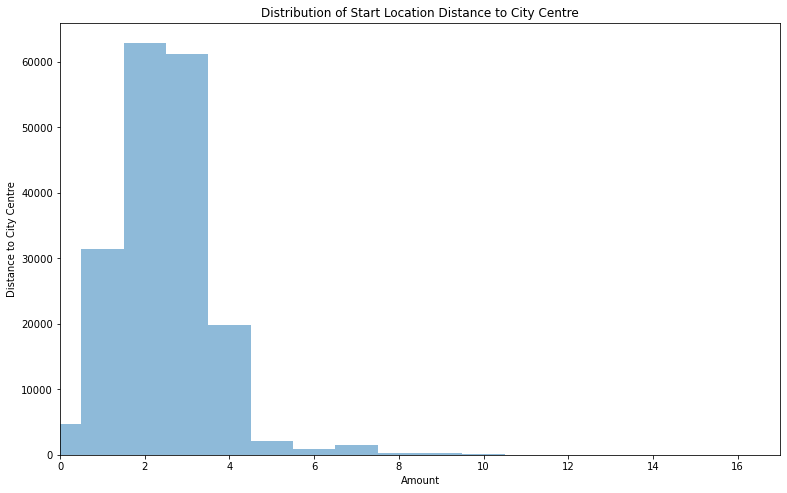

In [14]:
df["max_distance_center"] = df["max_distance_center"].round()

distances = df.groupby("max_distance_center").agg(
count = ("b_number","count"))

# Create a figure (empty work space)
Fig_1 = plt.figure(figsize=(10,6))

# Add axes to the figure
ax_1 = Fig_1.add_axes([0.5, 0.5, 1, 1]) #The dimensions [left, bottom, width, height] of the axes

x = distances.index
y1 = distances["count"]
start_bars = ax_1.bar(x,y1,width = 1,alpha = 0.5)


ax_1.set_xlabel('Amount') # Use set_ to start method
ax_1.set_ylabel('Distance to City Centre')
ax_1.set_title('Distribution of Start Location Distance to City Centre')

plt.xlim([0,17])
plt.show()

In [15]:
df_unrealistic = df[df["max_distance_center"]>15]
print(len(df_unrealistic.index),"have been filtered out due to being too far away from the city centre.")
df = df[df["max_distance_center"]<=15]

24 have been filtered out due to being too far away from the city centre.


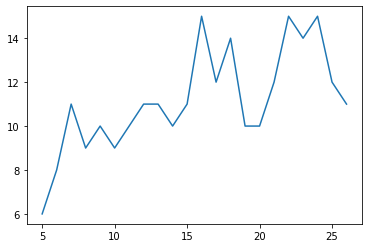

In [16]:
operating_area = df.groupby("week").agg(
    distance = ("max_distance_center","max"))
plt.plot(operating_area)

## Find out size of the fleet
The idea is that a bike is recognized as part of the fleet if it has been rented in the last 7 days. So the size of the fleet is the amount of unique Bike IDs that have records for the last 7 days. We calculate this on a daily level to be precise yet not too intense to compute.

In [17]:
factor = 7

start_date = df.date.min()
end_date = df.date.max()
delta = pd.to_timedelta("1d")

dates = []
while start_date <= end_date:
    dates.append(start_date)
    start_date += delta



fleet_size = pd.DataFrame([], index = dates, columns = ["search_array","fleet_size"]) 

search_array = []
for index, row in fleet_size.iterrows():
    search_array.append(index)
    if len(search_array) > factor:
        search_array.pop(0)
    row['search_array'] = search_array[:] #This just helps see if everything goes as expected
    row['fleet_size'] = df[df.date.isin(search_array[:])].b_number.nunique()
    


In [18]:
fleet_size.drop(columns=["search_array"], inplace = True)
fleet_size

,fleet_size
2019-02-01,256
2019-02-02,329
2019-02-03,350
2019-02-04,390
2019-02-05,421
...,...
2019-06-26,785
2019-06-27,787
2019-06-28,789
2019-06-29,795


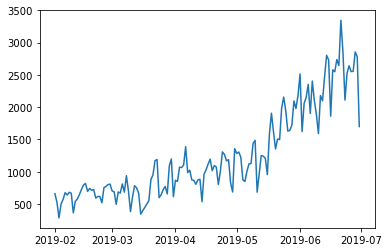

In [19]:
df_by_date = df.groupby("date").agg(
    revenue=('revenue', "sum"),
    trips=("b_number","count"),
    used_bikes=('b_number', pd.Series.nunique))

df_by_date_merged = df_by_date.join(fleet_size) #this does not include the missing days
df_by_date_merged["usage"] = df_by_date_merged["used_bikes"] / df_by_date_merged["fleet_size"]
df_by_date_merged = df_by_date_merged.rename(columns={"trips": "daily_trips","revenue":"daily_revenue", "used_bikes":"daily_used_bikes"})
df_by_date_merged = pd.merge( df_by_date_merged, date_info, left_index=True, right_index=True)

df_by_date_merged = df_by_date_merged.drop(columns=["date"])
df_by_date_merged


plt.plot(df_by_date.index,df_by_date_merged.daily_trips)

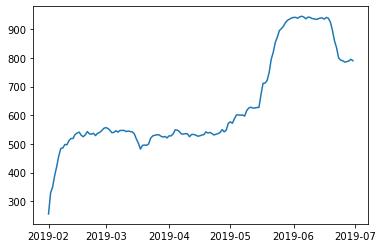

In [20]:
plt.plot(fleet_size.index,fleet_size.fleet_size)

In [21]:
df_by_hour = df.groupby("timestamp_rounded").agg(
    revenue=('revenue', "sum"),
    trips=("b_number","count"),
    date=("date","min"),
    weekday=("weekday","min"),
    week = ("week","min"),
    time = ("Time","min"),
    used_bikes=('b_number', pd.Series.nunique))


df_by_hour_merged = pd.merge(df_by_hour, df_by_date_merged, right_index=True, left_on='date')


df_by_hour_merged["usage"] = df_by_hour_merged["used_bikes"] / df_by_hour_merged["fleet_size"]
df_by_hour_merged["relative_trips"] = df_by_hour_merged["trips"] / df_by_hour_merged["daily_trips"]



df_by_hour_merged

,revenue,trips,date,weekday,week,time,used_bikes,daily_revenue,daily_trips,daily_used_bikes,fleet_size,usage,day_classifier,vacations,holiday,relative_trips
timestamp_rounded,,,,,,,,,,,,,,,,
2019-02-01 00:00:00,9.0,8,2019-02-01,4,5,0,8,785.0,659,256,256,0.03125,weekday,0,0,0.012140
2019-02-01 01:00:00,9.0,7,2019-02-01,4,5,1,7,785.0,659,256,256,0.0273438,weekday,0,0,0.010622
2019-02-01 02:00:00,7.0,2,2019-02-01,4,5,2,2,785.0,659,256,256,0.0078125,weekday,0,0,0.003035
2019-02-01 03:00:00,3.0,3,2019-02-01,4,5,3,3,785.0,659,256,256,0.0117188,weekday,0,0,0.004552
2019-02-01 04:00:00,9.0,8,2019-02-01,4,5,4,8,785.0,659,256,256,0.03125,weekday,0,0,0.012140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-30 19:00:00,112.0,90,2019-06-30,6,26,19,85,2174.0,1700,499,790,0.107595,weekend,0,0,0.052941
2019-06-30 20:00:00,104.0,87,2019-06-30,6,26,20,82,2174.0,1700,499,790,0.103797,weekend,0,0,0.051176
2019-06-30 21:00:00,82.0,66,2019-06-30,6,26,21,62,2174.0,1700,499,790,0.078481,weekend,0,0,0.038824


# Task 2

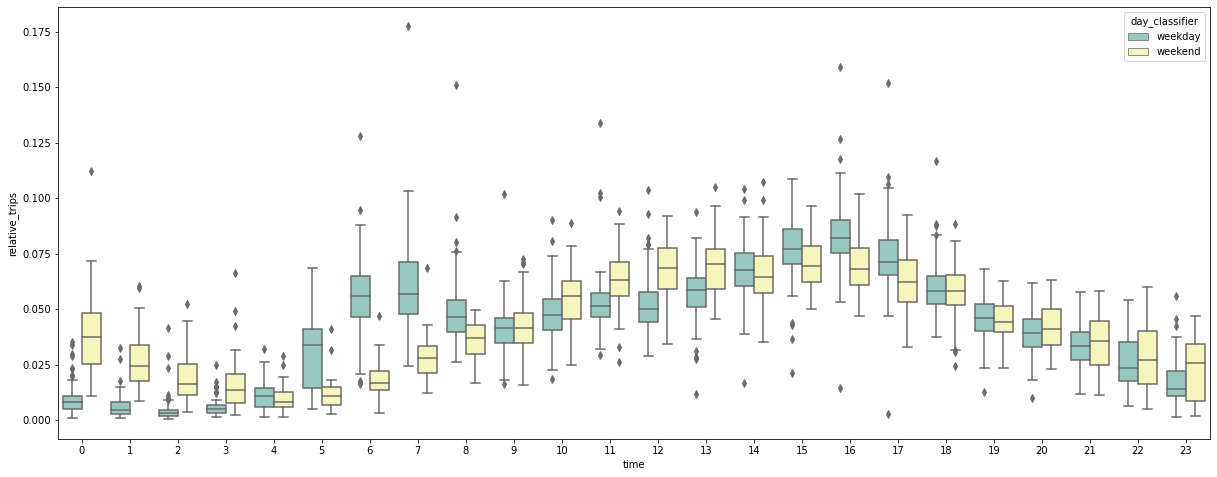

In [22]:
daily_trend = df_by_hour_merged[["time","day_classifier","relative_trips"]]

# Create a figure (empty work space)
Fig_1 = plt.figure(figsize=(16,6))

# Add axes to the figure
ax_1 = Fig_1.add_axes([0.5, 0.5, 1, 1]) #The dimensions [left, bottom, width, height] of the axes


sns.boxplot(ax = ax_1,
                 data=daily_trend, 
                 x="time", 
                 y="relative_trips", 
                 hue='day_classifier', 
                 palette="Set3")


In [23]:
df_by_date_merged.head()

,daily_revenue,daily_trips,daily_used_bikes,fleet_size,usage,day_classifier,vacations,holiday
date,,,,,,,,
2019-02-01,785.0,659,256,256,1,weekday,0,0
2019-02-02,664.0,526,241,329,0.732523,weekend,0,0
2019-02-03,352.0,285,162,350,0.462857,weekend,0,0
2019-02-04,623.0,499,237,390,0.607692,weekday,0,0
2019-02-05,654.0,573,251,421,0.5962,weekday,0,0


____

# Predictive Analytics

In [24]:
#Calculating the best Raster Point that is closest to the city center
testset_weather = pd.read_csv("./weather-data/dwd-raster/target/ra190201_target.csv") 

distances_center = []
for index, row in testset_weather.iterrows():
        d = {
            "LON": row["LON"],
            "LAT": row["LAT"],
            "ID": row["ID"],
            "distance": calculate_distance(row["LON"], row["LAT"], leipzig["lng"], leipzig["lat"])
        } 
        distances_center.append(d)
distances_center = pd.DataFrame(distances_center)

raster_id = distances_center.iloc[distances_center["distance"].idxmin()]["ID"]

In [25]:
#Read in CDC Raster Data from single files and Filter for the calculated point
import os

path = './weather-data/dwd-raster/target/'
rain_data_all = pd.concat((pd.read_csv(path+filename) for filename in os.listdir(path)))

rain_data = rain_data_all[rain_data_all["ID"] == raster_id]
rain_data.index = dates #indexing
rain_data.drop(columns=["ID"],inplace=True) 

C:\Users\Install\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [26]:
#Meteostat Data read-in
meteostat_leipzig = pd.read_csv("./weather-data/meteostat-leipzig.csv") 
meteostat_leipzig.index = dates
meteostat_leipzig.drop(columns=["wpgt","wdir","date"],inplace=True)

meteostat_leipzig.isnull().sum().sort_values(ascending=False)

#plt.plot(rain_data.index,rain_data.VAL)
#plt.plot(meteostat_leipzig.index,meteostat_leipzig.prcp)

tsun    0
pres    0
wspd    0
snow    0
prcp    0
tmax    0
tmin    0
tavg    0
dtype: int64

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [28]:
df_predictive = df_by_date_merged
df_predictive["weekday_dummy"] = df_predictive["day_classifier"].isin(["weekday"]).astype(int)
df_predictive = df_predictive.join(meteostat_leipzig)
df_predictive = df_predictive.drop(columns={"day_classifier","usage","daily_revenue","daily_used_bikes"})
df_predictive

,daily_trips,fleet_size,vacations,holiday,weekday_dummy,tavg,tmin,tmax,prcp,snow,wspd,pres,tsun
date,,,,,,,,,,,,,
2019-02-01,659,256,0,0,1,0.7,-2.3,3.3,0.0,0,6,995.2,0
2019-02-02,526,329,0,0,0,1.2,0.7,1.6,0.0,0,5,997.3,0
2019-02-03,285,350,0,0,0,0.7,0.2,1.1,4.7,30,11,1013.9,0
2019-02-04,499,390,0,0,1,0.8,-1.6,4.7,0.0,30,9,1028.2,470
2019-02-05,573,421,0,0,1,1.4,-0.5,3.8,0.0,20,9,1027.9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-26,2552,785,0,0,1,29.4,21.5,36.6,0.0,0,14,1020.1,750
2019-06-27,2555,787,0,0,1,20.5,15.3,26.2,0.0,0,17,1023.9,768
2019-06-28,2857,789,0,0,1,18.2,13.5,24.0,0.0,0,7,1024.5,513


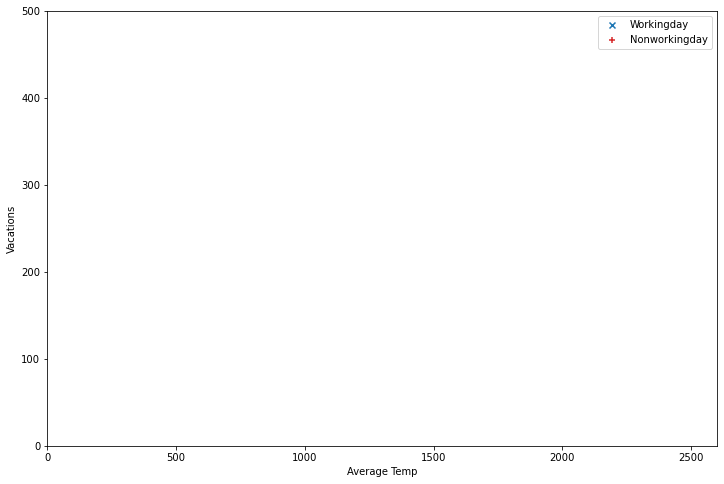

In [29]:
def plot_cells():
    plt.figure(figsize=(12,8))
    plt.scatter(df_predictive[df_predictive["weekday_dummy"]=='0']['tavg'], df_predictive[df_predictive["weekday_dummy"]=='0']['daily_trips'], marker='x', color='C0')
    plt.scatter(df_predictive[df_predictive["weekday_dummy"]=='1']['tavg'], df_predictive[df_predictive["weekday_dummy"]=='1']['daily_trips'], marker='+', color='C3')
    plt.xlim([0,2600])
    plt.ylim([0,500])
    plt.xlabel("Average Temp")
    plt.ylabel("Vacations")
    plt.legend(['Workingday', 'Nonworkingday'])
    
plot_cells()

## Arima Model?

In [39]:
# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv

from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# split into train and test sets
X = df_predictive.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(97,13,13))
    model_fit = model.fit()
output = model_fit.forecast()
yhat = output[0]
predictions.append(yhat)
obs = test[t]
history.append(obs)
print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

ValueError: SARIMAX models require univariate `endog`. Got shape (97, 13).

## Linear Regression

In [194]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline
# %config InlineBackend.figure_format = 'svg'

In [195]:
df_predictive

,daily_trips,fleet_size,vacations,holiday,weekday_dummy,tavg,tmin,tmax,prcp,snow,wspd,pres,tsun
date,,,,,,,,,,,,,
2019-02-01,659,256,0,0,1,0.7,-2.3,3.3,0.0,0,6,995.2,0
2019-02-02,526,329,0,0,0,1.2,0.7,1.6,0.0,0,5,997.3,0
2019-02-03,285,350,0,0,0,0.7,0.2,1.1,4.7,30,11,1013.9,0
2019-02-04,499,390,0,0,1,0.8,-1.6,4.7,0.0,30,9,1028.2,470
2019-02-05,573,421,0,0,1,1.4,-0.5,3.8,0.0,20,9,1027.9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-26,2552,785,0,0,1,29.4,21.5,36.6,0.0,0,14,1020.1,750
2019-06-27,2555,787,0,0,1,20.5,15.3,26.2,0.0,0,17,1023.9,768
2019-06-28,2857,789,0,0,1,18.2,13.5,24.0,0.0,0,7,1024.5,513


Text(0, 0.5, 'Daily Trips')

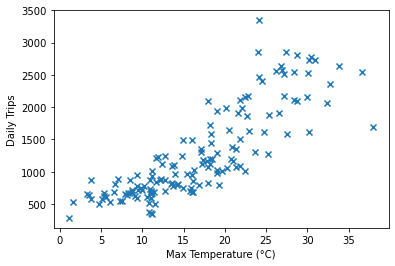

In [196]:
# note: we are using here the very powerful map() function, which returns a list of the results 
# after applying the given function to each item of a given iterable (list, tuple etc.)

#df_weekday = df_predictive[list(map(lambda x : str(x)[0:1] in ["06", "07", "08"], df.index))].copy()

plt.scatter(df_predictive["tmax"], df_predictive["daily_trips"], marker='x')
plt.xlabel("Max Temperature (°C)")
plt.ylabel("Daily Trips")
#plt.savefig('peak demand summer.png', dpi = 300)

In [197]:
model = LinearRegression(fit_intercept =True)

In [198]:
Xp = df_predictive["tavg"].values
Yp = df_predictive["daily_trips"].values

In [199]:
model.fit (df_predictive["tmax"].values.reshape(-1,1),df_predictive["daily_trips"])
model_pred = model.predict(df_predictive["tmax"].values.reshape(-1,1))

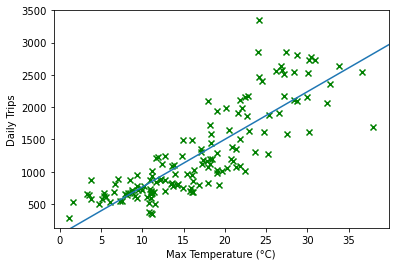

[73.74819673] 26.862649065528558
The R^2 of linear regression is:  0.7052260015094076


In [200]:
plt.scatter( df_predictive["tmax"] ,df_predictive["daily_trips"], marker = 'x', c='g')
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())

Z = np.linspace(0,40)
T = model.intercept_ + model.coef_*Z

plt.plot(Z,T)
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("Max Temperature (°C)")
plt.ylabel("Daily Trips")
plt.show()
print(model.coef_, model.intercept_)
print ('The R^2 of linear regression is: ',r2_score(df_predictive["daily_trips"], model_pred))

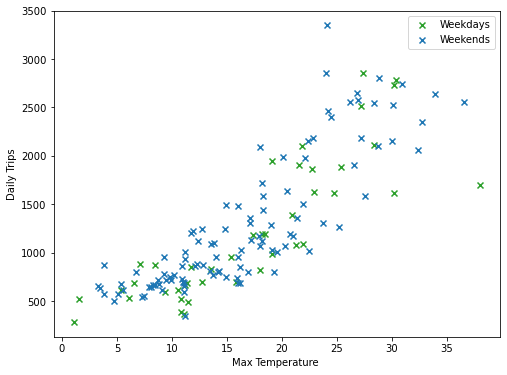

In [201]:
#Weekday Version
plt.figure(figsize = (8,6))
plt.scatter(df_predictive[df_predictive["weekday_dummy"]==0]["tmax"], 
            df_predictive[df_predictive["weekday_dummy"]==0]["daily_trips"], marker='x', color='C2')
plt.scatter(df_predictive[df_predictive["weekday_dummy"]==1]["tmax"], 
            df_predictive[df_predictive["weekday_dummy"]==1]["daily_trips"], marker='x', color='C0')
plt.xlabel("Max Temperature ")
plt.ylabel("Daily Trips")
plt.legend(["Weekdays", "Weekends"])
plt.show()

In [202]:
X = df_predictive[["tmax", "weekday_dummy"]]
y = df_predictive[["daily_trips"]]
lin_mod_day = LinearRegression()
lin_mod_day.fit(X,y)
print(lin_mod_day.coef_, lin_mod_day.intercept_)

[[ 73.91637778 102.66171967]] [-49.28057933]


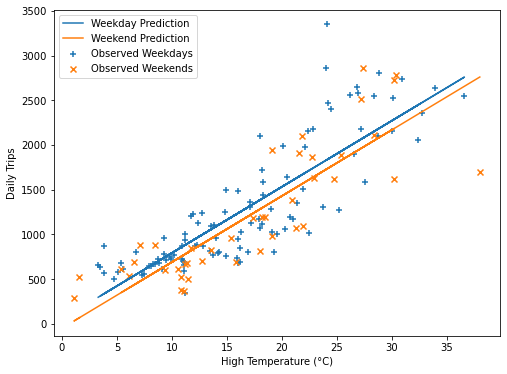

In [203]:
X_weekday = X[X["weekday_dummy"]==1]
X_weekend = X[X["weekday_dummy"]==0]

# predict weekends and weekdays seperately
y_pred_weekday = lin_mod_day.predict(X_weekday)
y_pred_weekend = lin_mod_day.predict(X_weekend)

plt.figure(figsize = (8,6))

plt.scatter(X_weekday["tmax"], 
            df_predictive[df_predictive["weekday_dummy"]==1]["daily_trips"], 
            marker="+", label="Observed Weekdays")

plt.scatter(X_weekend["tmax"], 
            df_predictive[df_predictive["weekday_dummy"]==0]["daily_trips"], 
            marker="x", label="Observed Weekends")

plt.plot(X_weekday["tmax"], 
         y_pred_weekday, 
         label="Weekday Prediction")
plt.plot(X_weekend["tmax"], 
         y_pred_weekend, 
         label="Weekend Prediction")

plt.xlabel("High Temperature (°C)")
plt.ylabel("Daily Trips")

plt.legend()
plt.show()

## Nonlinear modeling

In [204]:
xp = df_predictive["tmax"].values
yp = df_predictive["daily_trips"].values
xa = df_predictive["tavg"].values

Text(0, 0.5, 'Daily Trips')

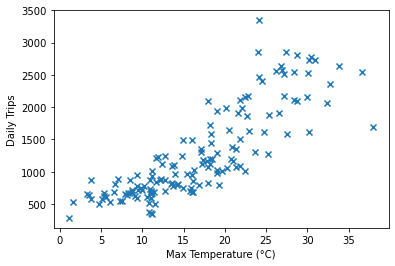

In [205]:
plt.scatter(xp, yp, marker="x")
plt.xlabel("Max Temperature (°C)")
plt.ylabel("Daily Trips")

The R^2 of linear regression is:  0.7052260015094076


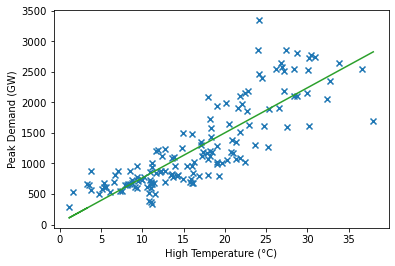

In [206]:
lr = LinearRegression()
lr.fit(xp.reshape(-1,1), yp)
model_pred_p = lr.predict(xp.reshape(-1,1))

plt.scatter(xp, yp, marker="x" )
plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")
plt.plot(xp, model_pred_p, c='C2')
print ('The R^2 of linear regression is: ',r2_score(yp, model_pred_p))

[ 256.63377475 1399.46124038 1421.29999473]


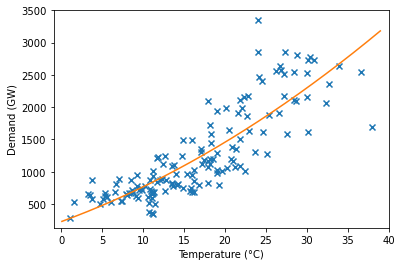

In [207]:
# x is the input variable
# y is the output vaiable
# d is degree pf polynomial regression

def plot_regression_poly(x, y, d):
    
    min_x, max_x = x.min(), x.max()
    xs = 2*(x - min_x)/(max_x - min_x)-1
    X = np.array([xs**i for i in range(d,-1,-1)]).T
    theta = np.linalg.solve(X.T @ X, X.T @ y)
    xt0 = np.linspace(min_x-1, max_x+1, 400)
    xt = 2* (xt0 - min_x)/(max_x - min_x) -1
    Xt = np.array([xt**i for i in range(d,-1,-1)]).T
    yt = Xt @ theta
        
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, yt, 'C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)
    print(theta[:4])
    #plt.savefig('all data_reg_'+str(d)+'.png', dpi = 300)
    
#Quadratic regression for demand data:
plot_regression_poly(x = xp, y=yp, d = 2)

[ 7.56174774e+09 -8.53605044e+09  9.56069737e+09  7.24297247e+09]


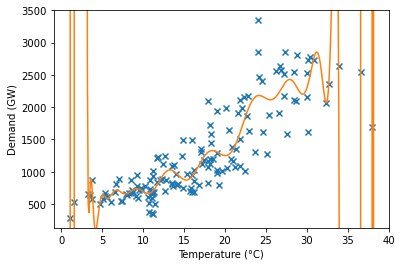

In [208]:
#qubic regression
# Plot of Peak demand vs. High temperature
plot_regression_poly(x = xp, y=yp, d = 100)

In [209]:
#Cross validation

X = np.array([df_predictive["tmax"].values, np.ones(len(df))]).T
np.random.seed(10)
perm = np.random.permutation(X.shape[0])
idx_train = perm[:int(len(perm)*0.7)]
idx_cv = perm[int(len(perm)*0.7):]

x_train, y_train = df_predictive["tmax"].iloc[idx_train].values, df_predictive["daily_trips"].iloc[idx_train].values
x_cv, y_cv = df_predictive["tmax"].iloc[idx_cv].values, df_predictive["daily_trips"].iloc[idx_cv].values

<ipython-input-209-3afccd218309>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X = np.array([df_predictive["tmax"].values, np.ones(len(df))]).T


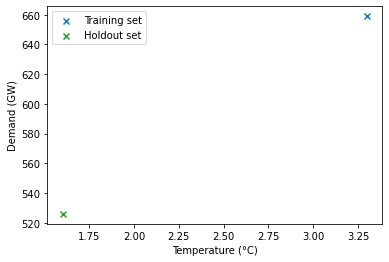

In [210]:
plt.scatter(x_train, y_train, marker='x', color="C0")
plt.scatter(x_cv, y_cv, marker='x', color="C2")
plt.xlabel("Temperature (°C)")
plt.ylabel("Demand (GW)")
plt.legend(['Training set', 'Holdout set'])
#plt.savefig('crossvalidation.png', dpi = 300)

<ipython-input-211-2d5416d3606a>:2: RuntimeWarning: invalid value encountered in true_divide
  x_train = 2*(x_train - min_x_train)/(max_x_train - min_x_train) - 1
<ipython-input-211-2d5416d3606a>:3: RuntimeWarning: divide by zero encountered in true_divide
  x_cv = 2*(x_cv - min_x_train)/(max_x_train - min_x_train) - 1


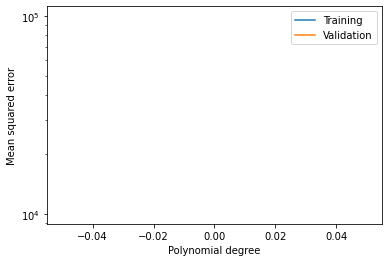

In [211]:
min_x_train, max_x_train = x_train.min(), x_train.max()
x_train = 2*(x_train - min_x_train)/(max_x_train - min_x_train) - 1
x_cv = 2*(x_cv - min_x_train)/(max_x_train - min_x_train) - 1

def poly_feat(x, degree):
    return np.array([x**i for i in range(degree,-1,-1)]).T

def ls_poly(x, y, degree):
    X = np.array([x**i for i in range(degree,-1,-1)]).T
    return np.linalg.solve(X.T @ X, X.T @ y)  


err_train = []
err_cv = []
for i in range(50):
    theta = ls_poly(x_train, y_train, i)
    err_train.append(((poly_feat(x_train,i) @ theta - y_train)**2).mean())
    err_cv.append(((poly_feat(x_cv,i) @ theta - y_cv)**2).mean())
plt.semilogy(range(50), err_train, range(50), err_cv)
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")
plt.savefig('crossvalidation error .png', dpi = 500)

Text(0, 0.5, 'Mean squared error')

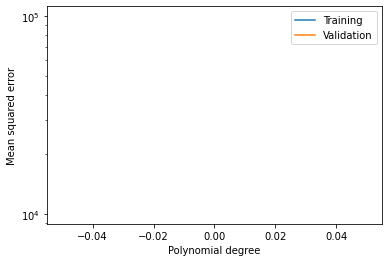

In [232]:
plt.semilogy(range(15), err_train[:15], range(15), err_cv[:15])
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")

## Decision Trees

In [224]:
#Cross validation using Scikit-learn library
from sklearn.model_selection import train_test_split

In [225]:
# split the data with 70% in each set
X_train, X_test, y_train, y_test = train_test_split(xp, yp, test_size=0.3)

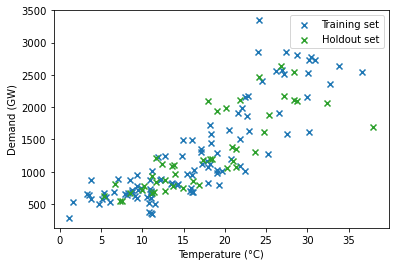

In [226]:
plt.scatter(X_train, y_train, marker='x', color="C0")
plt.scatter(X_test, y_test, marker='x', color="C2")
plt.xlabel("Temperature (°C)")
plt.ylabel("Demand (GW)")
plt.legend(['Training set', 'Holdout set'])

In [228]:
# fit the model on one set of data
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures (degree = 6)
x_poly = poly_reg.fit_transform(X_train.reshape(-1,1))

model = LinearRegression(normalize = True)
model.fit(x_poly, y_train)

# evaluate the model on the second set of data
y_pred = model.predict(poly_reg.fit_transform(X_test.reshape(-1,1)))
print ('The R^2 for quadratic curve is: ',r2_score(y_test, y_pred))

The R^2 for quadratic curve is:  0.6084359641997819


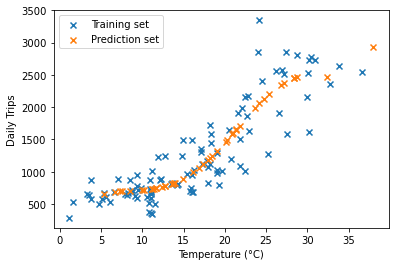

In [230]:
plt.scatter(X_train, y_train, marker='x', color="C0")
plt.scatter(X_test, y_pred, marker='x', color="C1")
plt.xlabel("Temperature (°C)")
plt.ylabel("Daily Trips")
plt.legend(['Training set', 'Prediction set'])

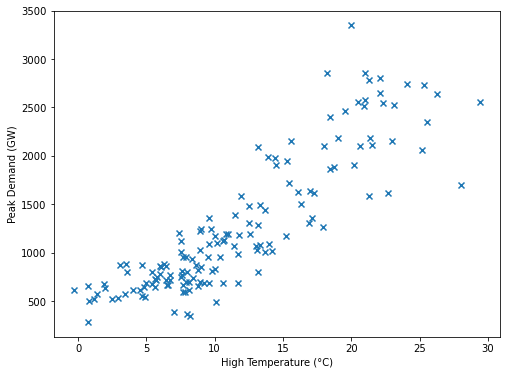

In [213]:
plt.figure(figsize = (8,6))
plt.scatter(Xp, Yp, marker="x")
plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")
plt.show()

In [214]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import r2_score

def plot_tree_regression_line(tree_depth):

    # Fit regression model (to full data)
    Tree_reg = DecisionTreeRegressor(max_depth=tree_depth,
                                    criterion="mse")
    Tree_reg.fit(Xp.reshape((-1,1)), Yp)
    Y_pred = Tree_reg.predict(Xp.reshape((-1,1)))
    
    attributes = Tree_reg.tree_

    # plot
    plt.figure(figsize = (8,6))
    plt.scatter(Xp, Yp, marker="x")
    plt.plot(np.arange(-18,40,1), Tree_reg.predict(np.arange(-18,40,1).reshape((-1,1))), marker="x", color='C1')
    plt.xlabel("Average Temperature (°C)", fontsize=16)
    plt.ylabel("Daily Trips", fontsize=16)
    
    print("number of nodes: ", attributes.node_count)
    print("number of leafs: ", attributes.n_leaves)
    print("R^2: ", r2_score(Yp, Y_pred))
    
    
    #plt.savefig("Peak_Power_Regression_Lines_{}depth.pdf".format(tree_depth))

number of nodes:  7
number of leafs:  4
R^2:  0.8247319622147705


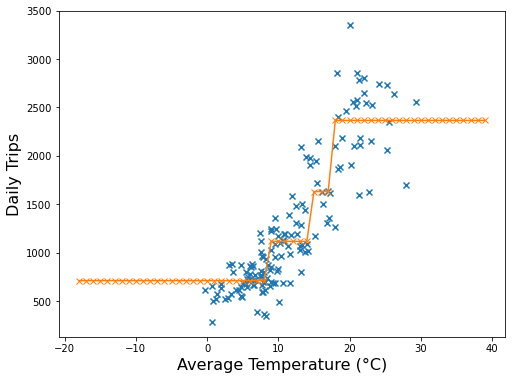

In [215]:

plot_tree_regression_line(2)

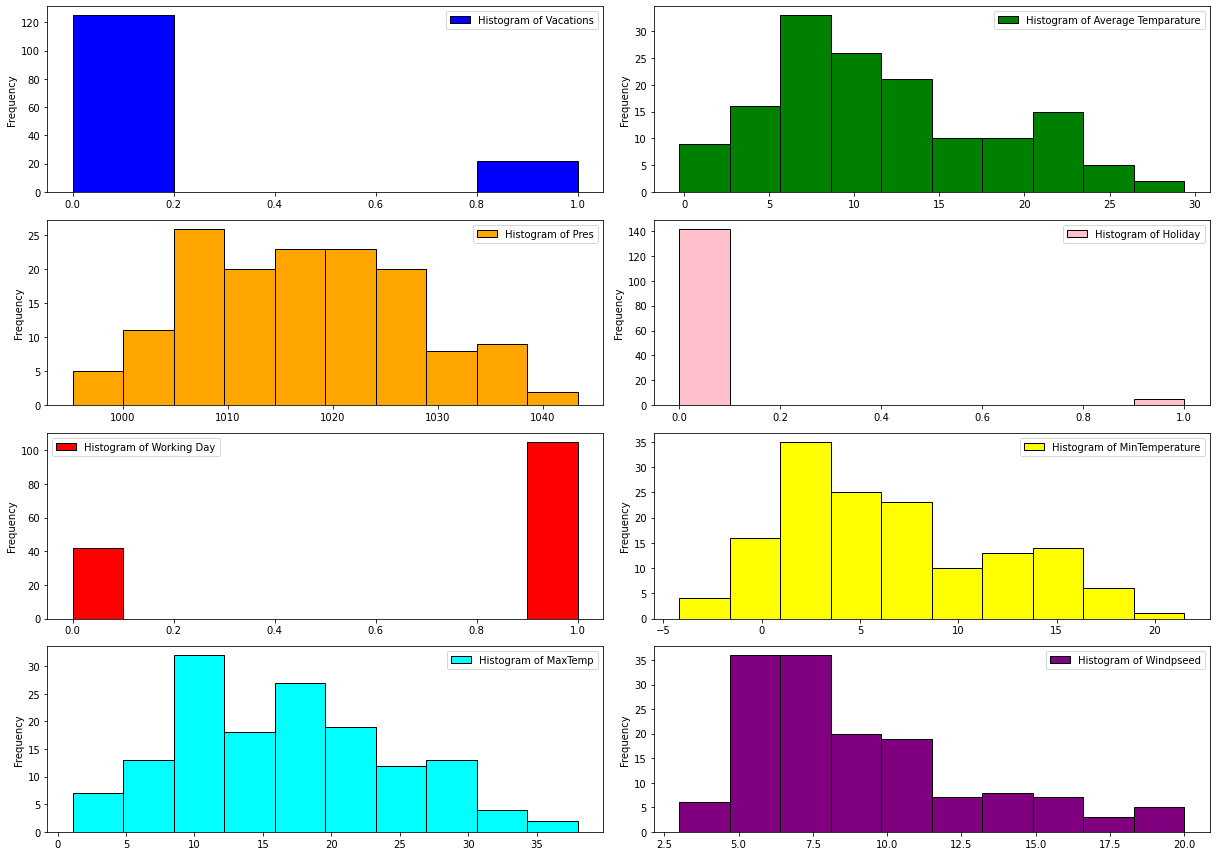

In [38]:
plt.figure(figsize=(17,12))
plt.subplot(421)
df_predictive['vacations'].plot.hist(bins=(5), color='blue', label='Histogram of Vacations', edgecolor='black')
plt.legend(loc='best')
plt.subplot(422)
df_predictive['tavg'].plot.hist(bins=10, color='green', label='Histogram of Average Temparature', edgecolor='black')
plt.legend(loc='best')
plt.subplot(423)
df_predictive['pres'].plot.hist(bins=10, color='orange', label='Histogram of Pres', edgecolor='black')
plt.legend(loc='best')
plt.subplot(424)
df_predictive['holiday'].plot.hist(bins=10, color='pink', label='Histogram of Holiday', edgecolor='black')
plt.legend(loc='best')
plt.subplot(425)
df_predictive['weekday_dummy'].plot.hist(bins=10, color='red', label='Histogram of Working Day', edgecolor='black')
plt.legend(loc='best')
plt.subplot(426)
df_predictive['tmin'].plot.hist(bins=10, color='yellow', label='Histogram of MinTemperature', edgecolor='black')
plt.legend(loc='best')
plt.subplot(427)
df_predictive['tmax'].plot.hist(bins=10, color='cyan', label='Histogram of MaxTemp', edgecolor='black')
plt.legend(loc='best')
plt.subplot(428)
df_predictive['wspd'].plot.hist(bins=10, color='purple', label='Histogram of Windpseed', edgecolor='black')
plt.legend(loc='best')
plt.tight_layout();

In [217]:
X = df_predictive.drop(columns=["daily_trips"])
Y = df_predictive[["daily_trips"]]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

R2: 0.8202776792464084


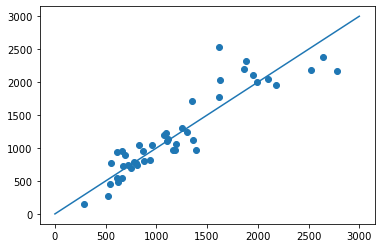

In [218]:
lin_reg_mod = LinearRegression()
lin_reg_mod.fit(X_train, Y_train)
pred = lin_reg_mod.predict(X_test)

test_set_r2 = r2_score(Y_test, pred)
plt.scatter(Y_test, pred)

x = np.linspace(0, 3000, 3000)
print("R2:", test_set_r2)
plt.plot(x,x)

In [231]:
# Segregating data based on ‘workingday’ column
work_day = df_predictive[df_predictive['weekday_dummy']==1] 
non_work_day = df_predictive[df_predictive['weekday_dummy']==0]
# Model for registered
x = work_day
y = work_day
    
# Dividing the data into train and test
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.30 ,random_state = 2)

_______________________________

### LSTM (Long Short-Term Memory)

In [220]:
#dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from sklearn.preprocessing import MinMaxScaler
df_predictive

,daily_trips,fleet_size,vacations,holiday,weekday_dummy,tavg,tmin,tmax,prcp,snow,wspd,pres,tsun
date,,,,,,,,,,,,,
2019-02-01,659,256,0,0,1,0.7,-2.3,3.3,0.0,0,6,995.2,0
2019-02-02,526,329,0,0,0,1.2,0.7,1.6,0.0,0,5,997.3,0
2019-02-03,285,350,0,0,0,0.7,0.2,1.1,4.7,30,11,1013.9,0
2019-02-04,499,390,0,0,1,0.8,-1.6,4.7,0.0,30,9,1028.2,470
2019-02-05,573,421,0,0,1,1.4,-0.5,3.8,0.0,20,9,1027.9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-26,2552,785,0,0,1,29.4,21.5,36.6,0.0,0,14,1020.1,750
2019-06-27,2555,787,0,0,1,20.5,15.3,26.2,0.0,0,17,1023.9,768
2019-06-28,2857,789,0,0,1,18.2,13.5,24.0,0.0,0,7,1024.5,513


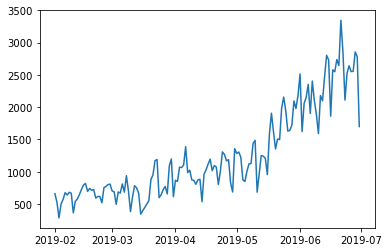

In [221]:
#Visualization
plt.plot(df_predictive["daily_trips"],label='Daily trips in Leipzig')

In [222]:
#Data Preparation
df = df_predictive.sort_index(ascending=True,axis=0)
data = pd.DataFrame(index=range(0,len(df)),columns=['Date','daily_trips'])

data.head()

,Date,daily_trips
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


In [223]:
#MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
data.index=data.Date
data.drop('date', axis=1,inplace=True)
final_data = data.values
train_data=final_data[0:200,:]
valid_data=final_data[200:,:]
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_data)
x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

KeyError: "['date'] not found in axis"

# Geographic Clustering for availability analysis

In [ ]:
locs = df[["orig_lat","orig_lng"]].rename(columns={"orig_lat": "lat","orig_lng":"lng"})
locs.append(df[["dest_lat","dest_lng"]].rename(columns={"dest_lat": "lat","dest_lng":"lng"}),ignore_index=True)
locs

In [ ]:
from sklearn.cluster import MiniBatchKMeans, KMeans

ssd = []
for i in range(2, 60):
    km = MiniBatchKMeans(n_clusters=i)
    km.fit_predict(locs)
    ssd.append(km.inertia_)
    
plt.plot(ssd)

In [ ]:
n = 40

km = MiniBatchKMeans(n_clusters=n)
km.fit_predict(locs)
clusters = pd.DataFrame(km.cluster_centers_)
clusters.columns = ['lat', 'lng']
clusters_gdf = gpd.GeoDataFrame(
    clusters.drop(["lat","lng"],axis=1), geometry=gpd.points_from_xy(clusters["lng"], clusters["lat"]))

In [ ]:
locs_gdf = gpd.GeoDataFrame(
    locs.drop(["lat","lng"],axis=1), geometry=gpd.points_from_xy(locs["lng"], locs["lat"]))

In [ ]:
leipzig_map = gpd.read_file("./resources/leipzig/ot.shp").to_crs(epsg=4326) #original file is in a different system

fig, ax = plt.subplots(figsize=(30,20))

locs_gdf.plot(ax=ax, alpha=0.2, color = [0,0,0], markersize=10, zorder=2)
clusters_gdf.plot(ax=ax, alpha=0.7, color='cyan', markersize=75,  zorder=3)
leipzig_map.plot(ax=ax, alpha=0.4, edgecolor='darkgrey', color='lightgrey', zorder=1)

## Availability Analysis
This function calculates what happened between rental times. It analyzes whether, between rentals, a bike has been available at a certain station or whether it has been moved to a different location. This can then be used for example to calculate the number of available bikes at a certain station at a single time. We use it to calculate our KPI of percentage of stations without available bikes. It can be used for further analysis in this topic as well.

In [ ]:
round_factor = 2
df

In [ ]:
df2 = df[:]

df2["timestamp_end"] = df2["timestamp"] + df2["trip_duration"]
df2=df2.drop(columns=['date', 'date_str', "revenue", "Weekday", "Time", "timestamp_rounded","trip_duration"])

#df2 = df2.round({"orig_lat":round_factor, 'orig_lng':round_factor, 'dest_lat':round_factor, "dest_lng":round_factor})

#make sure it is sorted by b_number, then timestamp
df2 = df2.sort_values(by=['b_number','timestamp'])
#make sure the index is still +1 every time after sorting
df2.reset_index(inplace=True)
df2 = df2.rename(columns={"index": "original_index"})


df2

This step will take a while, as it clusters each entry to a specific cluster point, which takes a lot of computing power.

In [ ]:
df3 = []

bike_number = 0
bike_city = ""

for index in df2.index:
    if  df2.at[index,"b_number"] != bike_number:
        bike_number = df2.at[index,"b_number"]
        bike_city = df2.at[index,"city"]
    else:
        lat = df2.at[index,"orig_lat"]
        lng = df2.at[index,"orig_lng"]
        cluster_point = next_cluster(lng,lat,clusters)
        time_start = df2.at[index-1,"timestamp_end"]
        time_end = df2.at[index,"timestamp"]
        
        #test if it is working
        if index % 20000 == 0:
            print("reached row", index, "of", df2.index.max())
        
        action_type = "station"
        if lat == df2.at[index-1,"dest_lat"] and lng != df2.at[index-1,"dest_lng"]:
            action_type = "moved"
            
        d = {
            'b_number' : bike_number,
            'b_city' : bike_city,
            'lat' : lat,  # some formula for obtaining values
            'lng' : lng,
            'timestamp' : time_start,
            'action_type' : action_type+"_in",
            'cluster_point': cluster_point
            }
        df3.append(d)
        d = {
            'b_number' : bike_number,
            'b_city' : bike_city,
            'lat' : lat,  # some formula for obtaining values
            'lng' : lng,
            'timestamp' : time_end,
            'action_type' : action_type+"_out",
            'cluster_point': cluster_point
            }
        df3.append(d)

df3 = pd.DataFrame(df3)

In [ ]:
df3["cluster_point"] = df3["cluster_point"].astype(str)
df3

This algorithm takes goes over all records that relate to bikes standing at a certain station. For each change event, it calculates the effect on the capacity of a certain station.

In [ ]:
#filter df3 for all events related to bikes standing at a station (not being moved between rides)
df3 = df3[df3["action_type"].isin(["station_in","station_out"])]

#filter correctly for the algorithm to work properly
df3=df3.sort_values(by=['cluster_point','timestamp','action_type'])
df3.reset_index(inplace=True)
df3 = df3.rename(columns={"index": "original_index"})

df3["count"] = 0

station = ""
count = 0

for index in df3.index:
    action_type = df3.at[index,"action_type"]
    #if this is a different station, restart the calculation
    if  df3.at[index,"cluster_point"] != station:
        station = df3.at[index,"cluster_point"]
        count = 0
    if action_type == "station_in":
         count = count + 1
    elif action_type == "station_out":
        count = count - 1
    else:
        print("there was an error")
    
    df3.at[index,"count"] = count

In [ ]:
df3

This part produces a list of the minimum available bikes at a certain station. For example, if a station has had 2 bikes for the first ten minutes, then had 3 and in the end had only 1 bike left, this would count as 1 bike for the respective hour period. 
* If there was no change in available bikes, it takes the value for the most recent change event.
* If the number of available bikes changes to zero and no bikes ever get to the station again until the end of the data timeframe, it will not count as 0 bikes as the station might have been closed in the meantime (this should not count as "no bikes available)

In [ ]:
df3["timestamp_rounded"] = df3["timestamp"].dt.floor("H")
df3 = df3.sort_values(by=['cluster_point','timestamp'])

start_date = df3.timestamp_rounded.min()
end_date = df3.timestamp_rounded.max()
daterange = pd.date_range(start_date, end_date,freq='1H')

df4 = pd.DataFrame(index=daterange)

for cluster_point in df3.cluster_point.unique():
    dfl = df3[df3.cluster_point == cluster_point]
    dfl = dfl.groupby("timestamp_rounded").agg(
    min_count =("count","min"),
    last_value = ("count", lambda x: x.iloc[-1]))
    dfl = dfl.reindex(daterange, fill_value=None)
    dfl["last_value"] = dfl["last_value"].fillna(method='ffill')
    dfl["min_count"] = dfl.apply(
        lambda row: row['last_value']if np.isnan(row['min_count']) else row['min_count'],axis=1
    )
    for index, row in dfl[::-1].iterrows():
        if row["min_count"] == 0:
            row["min_count"] = None
        else:
            break
    df4[cluster_point] = dfl["min_count"]
    
df4 = df4.T

In [ ]:
#df4.to_excel("transposed.xlsx")
df5 = df4[df4 < 4].count()
df5
plt.plot(df5)

In [ ]:
plt.plot(fleet_size)

_______________________________

## Visualisation

In [ ]:
dates = df_by_date_merged.index
fleetsize = df_by_date_merged["fleet_size"]
usage = df_by_date_merged["usage"]
usedbikes = df_by_date_merged["used_bikes"]

Fig_1, ax_1 = plt.subplots()


color = 'tab:red'
ax_1.set_xlabel('Date')
ax_1.set_ylabel('Fleet Size', color=color)
ax_1.plot(dates, fleetsize, color=color)
ax_1.tick_params(axis='y', labelcolor=color)

ax_2 = ax_1.twinx()  # instantiate a second axes that shares the same x-axis


color = 'tab:blue'

ax_2.set_ylabel("Used Bikes", color=color)
ax_2.plot(dates, usedbikes, color=color)
ax_2.tick_params(axis='y', labelcolor=color)

Fig_1.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

## Group by rounded start time

In [ ]:
df_by_time = df.groupby("Time").agg(
    mean_length=('trip_duration', lambda x: np.mean(x)),
    trip_count=('b_number', 'count'))

In [ ]:
fig, (ax1, ax1_b) = plt.subplots(nrows = 1, ncols = 2, figsize= (12,4))

x = df_by_time.index
seconds = df_by_time["mean_length"].dt.total_seconds()/60
amount = df_by_time["trip_count"]

color = 'tab:red'
ax1.set_xlabel('Time of the day')
ax1.set_ylabel('Average trip length', color=color)
ax1.plot(x, seconds, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Total amount of trips', color=color)  # we already handled the x-label with ax1
ax2.plot(x, amount, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()